In [1]:
#%matplotlib notebook
import time, winsound, h5py
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

In [3]:
def print_oe_pos(oe):
    print('{}, x:{}, y:{}, z:{}'.format(oe.name, oe.global_x, oe.global_y, oe.z))
    return oe.global_x, oe.global_y, oe.z

def Alarm(N):
    for i in range(N):
        winsound.Beep(1000,1000)
        time.sleep(1.1)

### Propagate central energy only (no time component)

In [4]:
def define_devices(f1 = 9.750953177257525, f2 = 10., crystal = 1,
                   slit_width = 500e-6, alphaAsym = np.deg2rad(27.98), E0=E0, f0 = 290.):
    # crystal reflection hkl index
    hkl = [6,6,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s')

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,
                              alphaAsym=alphaAsym, orientation=2,pol='s')
        
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=f2, diameter=5e-3)

    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2 + 1e-3, FOV=100e-6, N=256)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=f2, diameter=5e-3)
    
    # third crystal, asymmetric reflection, same orientation as crystal1
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z + f1, E0=E0,
                              alphaAsym=-alphaAsym, asym_type='emergence', orientation=2, pol='s')
    
    # viewing after crystal 3
    im1 = optics.PPM('after_c3', z=crystal3.z+.1,N=256,FOV=2e-3)

    # fourth crystal, symmetric reflection, same orientation as crystal2
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.2, E0=E0,
                              alphaAsym=0, asym_type='emergence', orientation=0, pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)

    # list of devices to propagate through
    devices = [crl0,im0,crystal1,crystal2, crl1, slit, focus, crl2, crystal3, im1, crystal4, im2]

    return devices

In [5]:
%%capture capt
tstart = time.time()
# initialize optical elements
f1 = 9.750953177257525
f2 = 10.

devices = define_devices(f1=f1, f2=f2)

# initialize beamline
mono_beamline = beamline.Beamline(devices)

for oe in devices:
    if oe.name == 'c1':
        print('crystal 1 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('crystal 1 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))

# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=4000)
pulse.propagate(beamline=mono_beamline, screen_names=['focus','im2'])
tfin = time.time()

In [6]:
print('each run: {}s, per slice: {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))
''' energy slices '''

each run: 8.22s, per slice: 92.4ms


' energy slices '

### Loops

In [10]:
%%capture capt
tstart = time.time()
NN = 300
shift_list = 1e-3*np.linspace(-1, 1, NN)

fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots_flip34/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])

fname = 'shift_tolerance_{}_{}keV'.format(
        hkl, round(beam_params['photonEnergy']/1000.,4))

for oe in ['c1','c2','crl1','slit','crl2','c3','c4']:
    # initialize results holder
    duration = np.zeros(NN)
    tilt = np.zeros(NN)
    bw = np.zeros(NN)
    throughput = np.zeros(NN)
    cent_E = np.zeros(NN)
    slit_width = 100e-6
    
    # pulse duration and tilt (open slit)
    for i, shift in enumerate(shift_list):
        devices = define_devices(f1=f1, f2=f2, slit_width=slit_width)
        mono_beamline = beamline.Beamline(devices)    # initialize beamline
        ''' add shift to beamline component '''
        for device in mono_beamline.device_list:
            if device.name == oe:
                device.z += shift
        beam_params['photonEnergy'] = E0    # reset central photon energy

        # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
        pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=4000)

        print('Number of spectral components: {:d}'.format(pulse.N))
        pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
        centroid, duration[i] = pulse.pulse_duration('im2')
        tilt[i] = pulse.pulsefront_tilt('im2')
    tfin = time.time()

    slit_width = 7e-6
    # else (closed slit)
    for i, shift in enumerate(shift_list):
        devices = define_devices(f1=f1, f2=f2, slit_width=slit_width)
        mono_beamline = beamline.Beamline(devices)    # initialize beamline
        ''' add shift to beamline component '''
        for device in mono_beamline.device_list:
            if device.name == oe:
                device.z += shift
        beam_params['photonEnergy'] = E0    # reset central photon energy

        # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
        pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=4000)

        print('Number of spectral components: {:d}'.format(pulse.N))
        pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
        bw[i] = pulse.pulse_bandwidth('im2')
        throughput[i] = pulse.throughput('im0','im2')
        cent_E[i] = pulse.central_energy('im2')
    tfin = time.time()

    # save results
    with h5py.File(fig_path+fname+'.h5', 'a') as f:
        grp = f.create_group(oe)
        grp.create_dataset('shift',data=shift_list)
        grp.create_dataset('pulse_duration', data=duration)
        grp.create_dataset('tilt', data=tilt)
        grp.create_dataset('bandwidth', data=bw)
        grp.create_dataset('throughput', data=throughput)
        grp.create_dataset('central_energy', data=cent_E)

Alarm(5)  

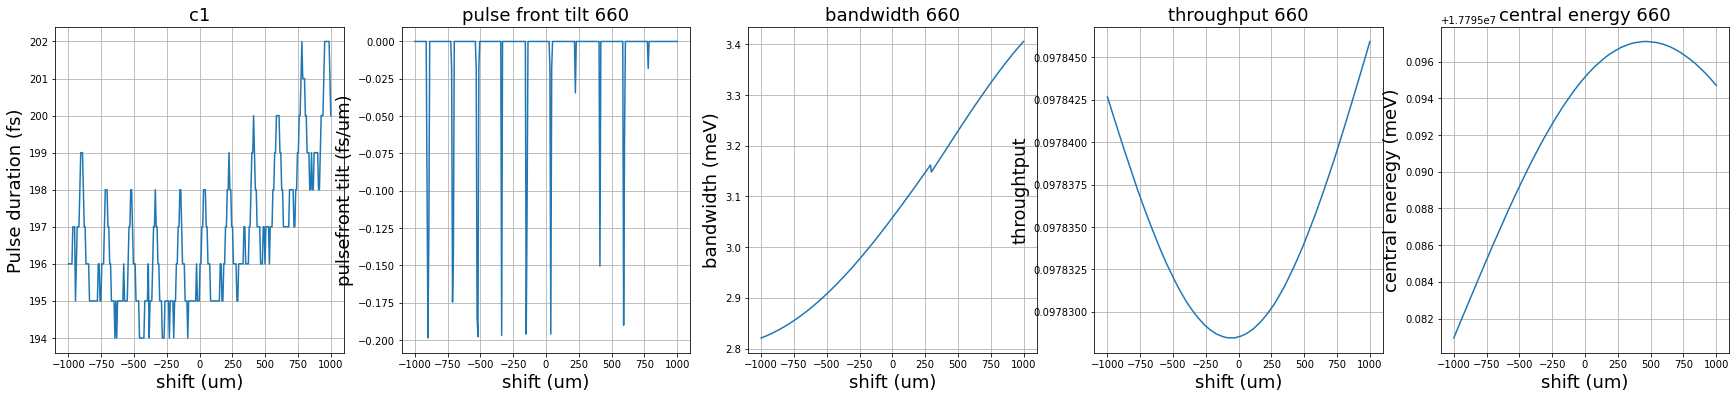

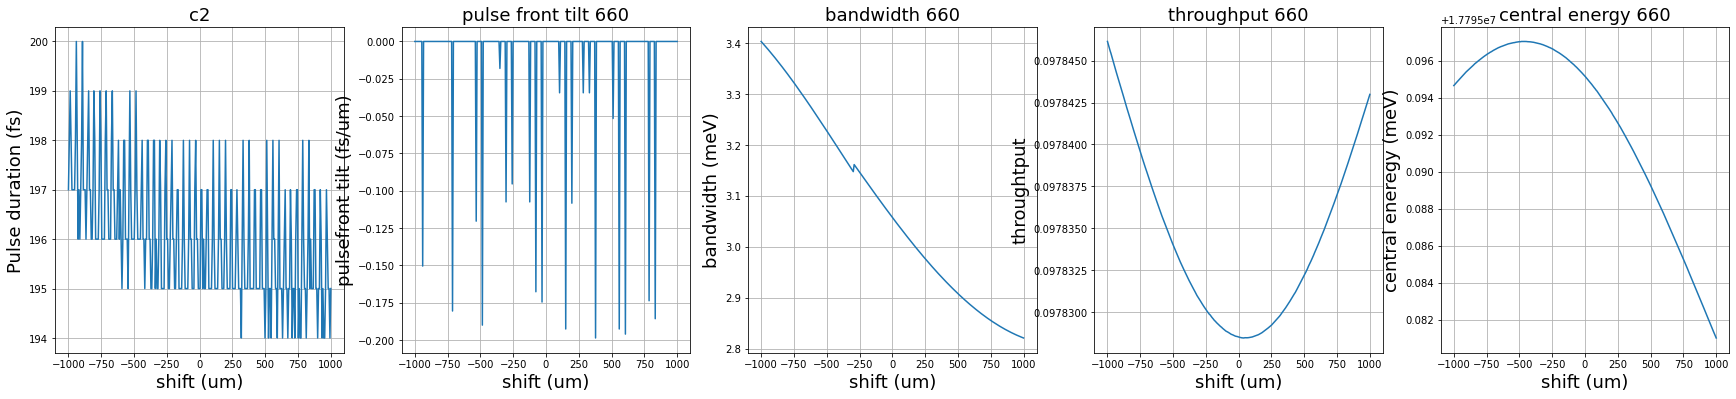

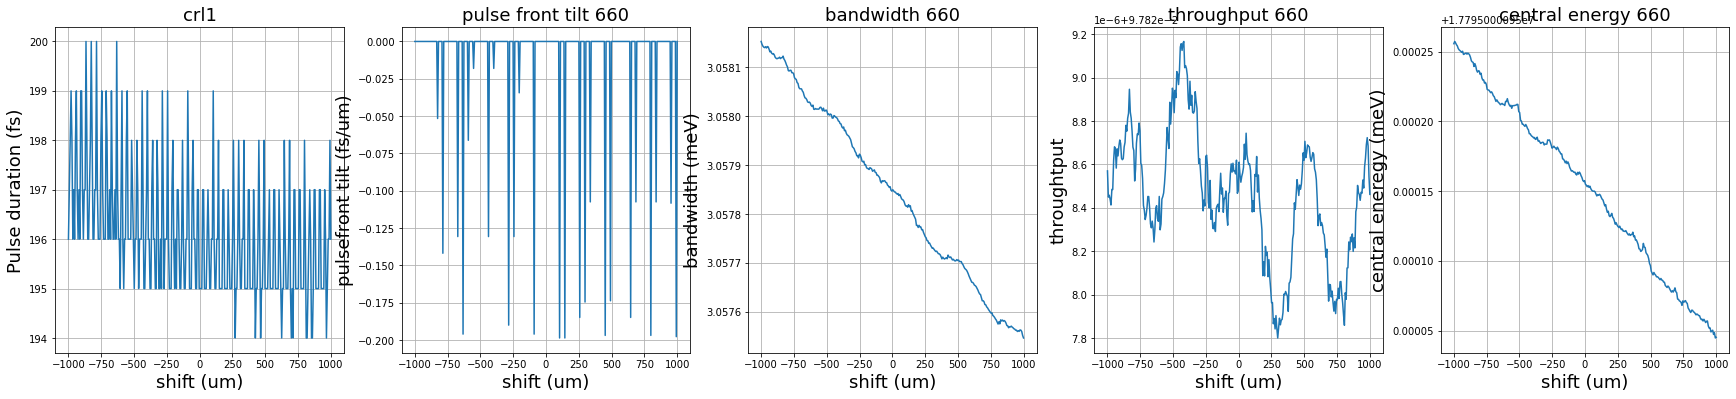

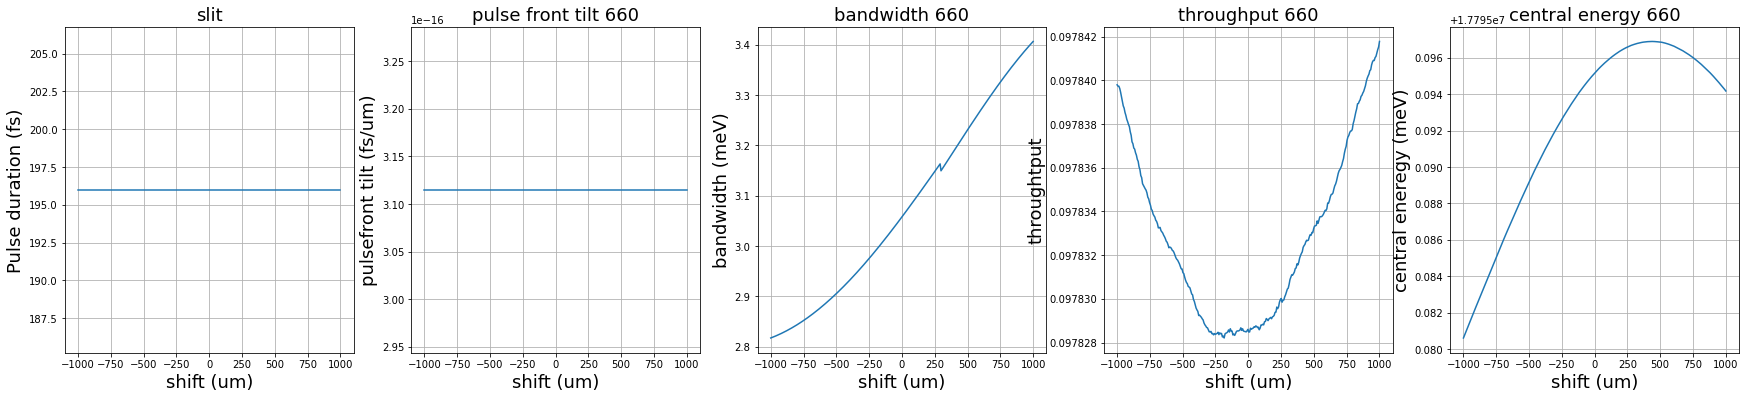

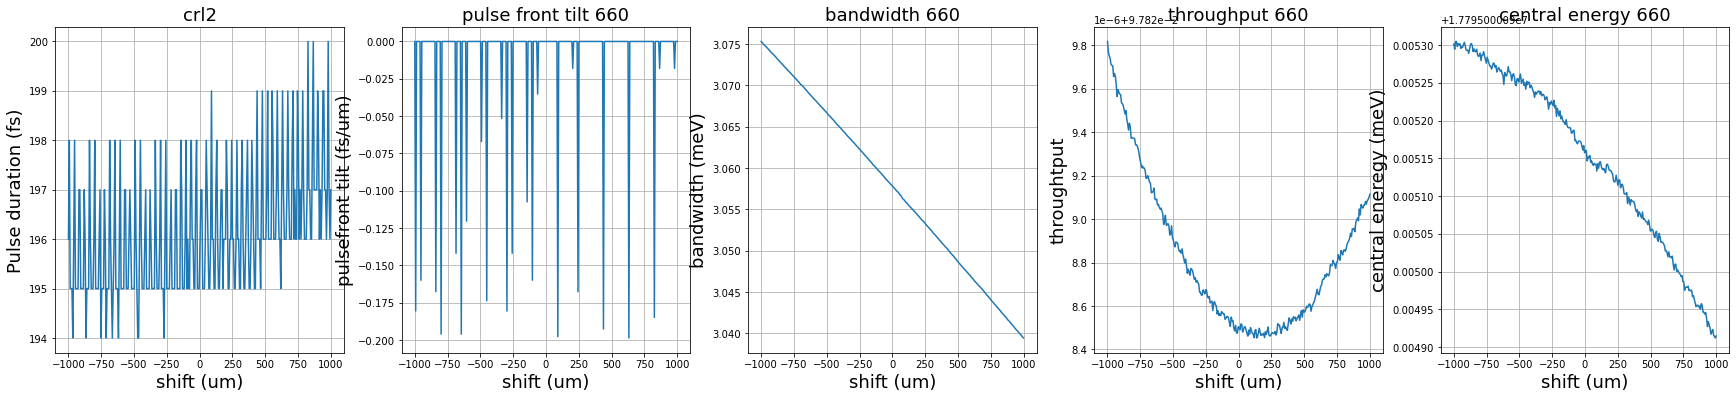

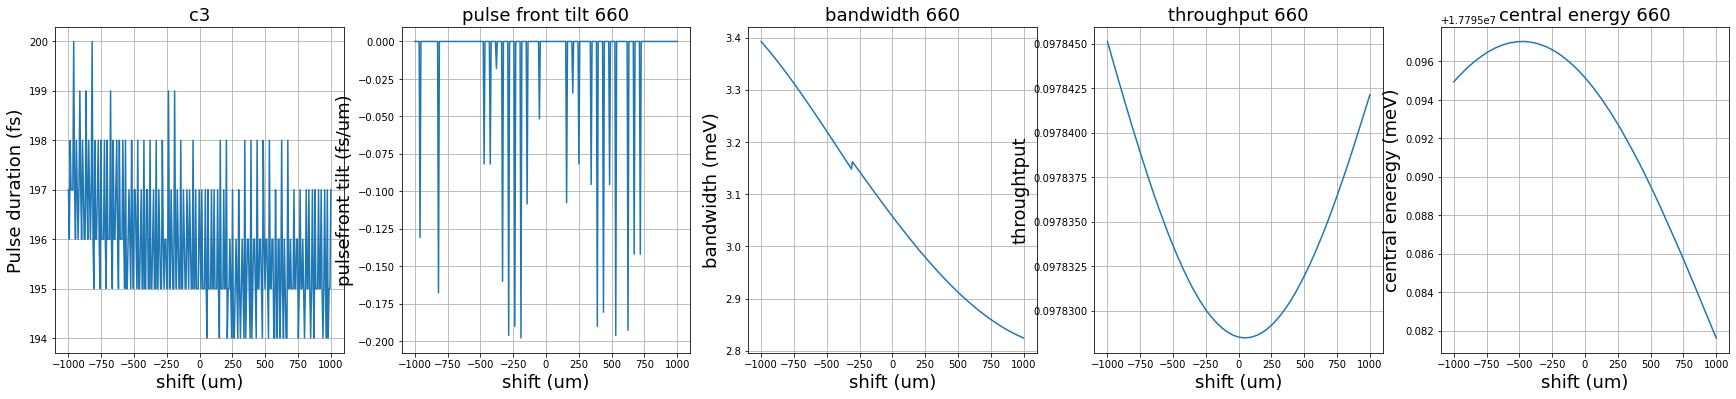

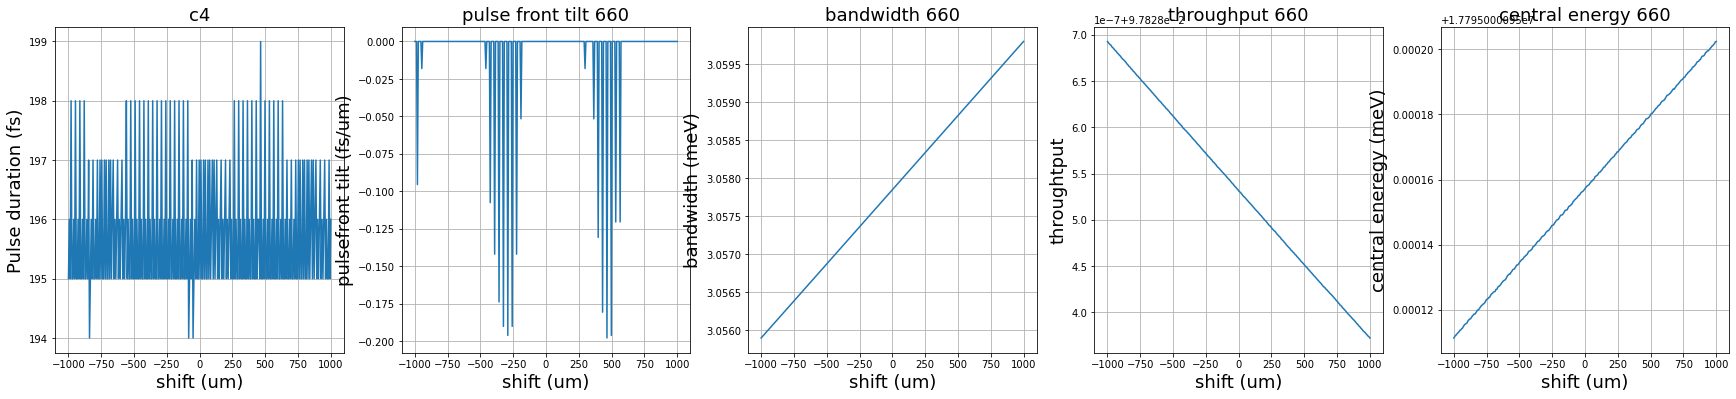

In [13]:
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots_flip34/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])

fname = 'shift_tolerance_{}_{}keV'.format(
        hkl, round(beam_params['photonEnergy']/1000.,4))

# plots
for oe in ['c1','c2','crl1','slit','crl2','c3','c4']:
    with h5py.File(fig_path+fname+'.h5', 'r') as f:
        grpname = oe
        shift_list = f[grpname+'/shift'][:]
        duration = f[grpname+'/pulse_duration'][:]
        tilt = f[grpname+'/tilt'][:]
        bw = f[grpname+'/bandwidth'][:]
        throughput = f[grpname+'/throughput'][:]
        cent_E = f[grpname+'/central_energy'][:]

    xx = shift_list * 1e6
    xlabel = 'shift (um)'

    # pulse duration
    plt.figure(figsize=(30,6))
    plt.subplot(1,5,1)
    plt.plot(xx, np.abs(duration))
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('pulse duration (fs)',fontsize=(18))

    plt.grid()
    plt.title(oe,fontsize=(18))

    # pulsefront tilt
    plt.subplot(1,5,2)
    plt.plot(xx, tilt)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('pulsefront tilt (fs/um)',fontsize=(18))

    plt.grid()
    plt.title('pulse front tilt {}'.format(hkl),fontsize=(18))
    # bandwidth
    plt.subplot(1,5,3)
    plt.plot(xx, 1e3*bw)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('bandwidth (meV)',fontsize=(18))

    plt.grid()
    plt.title('bandwidth {}'.format(hkl),fontsize=(18))

    # throughput
    plt.subplot(1,5,4)
    plt.plot(xx, throughput)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('throughtput',fontsize=(18))

    plt.grid()
    plt.title('throughput {}'.format(hkl),fontsize=(18))

    # central energy
    plt.subplot(1,5,5)
    plt.plot(xx, 1e3*cent_E)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('central eneregy (meV)',fontsize=(18))

    plt.grid()
    plt.title('central energy {}'.format(hkl),fontsize=(18))

    plt.savefig(fig_path+'{}_'.format(oe)+fname+'.png')


In [12]:
print('time per slice {}ms'.format(1000*(tfin-tstart)/7/2/NN/pulse.N))
print('total time {}s'.format(tfin-tstart))

time per slice 119.32476754045665ms
total time 44603.598106622696s
